<a href="https://colab.research.google.com/github/Jan-Novak00/Individual-Software-Project---dynamic-constraint-data-visualization/blob/main/kiwi_pokus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

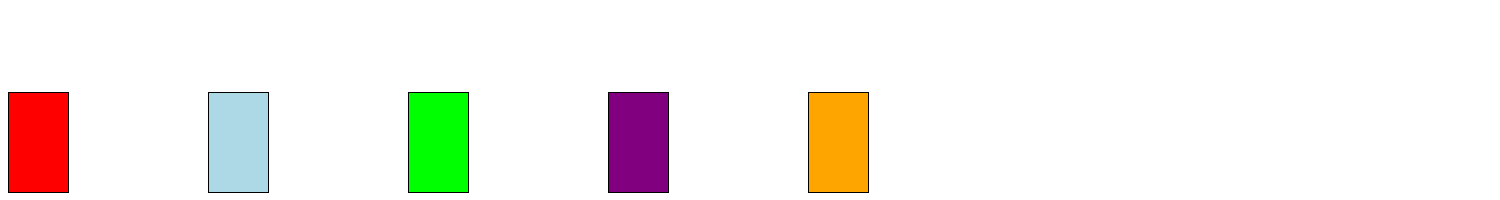

In [3]:
import kiwisolver
from kiwisolver import Variable, Constraint, Solver
from PIL import Image, ImageDraw
from IPython.display import display


class Rectangle:
    '''
    Rectangle class

    Represents the rectangle object
    '''
    def __init__(self, name: str, color: str | int = "blue"):
        self.name: str = name

        # Bottom left corner coordinates
        self.leftBottomX: kiwisolver.Variable = Variable(name+"LB"+"x")
        self.leftBottomY: kiwisolver.Variable = Variable(name+"LB"+"y")

        # Top right corner coordinates
        self.rightTopX: kiwisolver.Variable = Variable(name+"RT"+"x")
        self.rightTopY: kiwisolver.Variable = Variable(name+"RT"+"y")

        self.color: str | int = color


    def generateSizeConstraints(self, height: int, width: int):
        '''
        Returns predefined constraints for dimentions of the rectangle

        Parameters: height, width
        '''
        constraints = [self.rightTopX == self.leftBottomX + width, self.rightTopY == self.leftBottomY + height]
        return constraints


    def ToString(self):
        '''
        Returns coordinates of left bottom corner (LB) and right top corner (RT) as a string
        '''
        return f"{self.name}LB = ({self.leftBottomX.value()}, {self.leftBottomY.value()}), {self.name}RT = ({self.rightTopX.value()}, {self.rightTopY.value()})"



def generateInitialRectangleConstraints(rectangles: list[Rectangle], height: int, width: int, spacing: int):
    '''
    For a list of rectangles returns constraints which define their default dimentions and spacing ('weak' strength)
    All positions are relative.
    Adds constraints to keep all coordinates non-negative ('required' strength).

    Parameters: height, width, spacing

    '''
    constraints = []
    initialSizeConstraints = []
    initialPositionConstraints = []
    firstRectangle = rectangles[0]

    for rectangle in rectangles:
        initialSizeConstraints += [constraint | "weak" for constraint in rectangle.generateSizeConstraints(height, width)]
        initialPositionConstraints += [constraint | "required" for constraint in [rectangle.leftBottomX >= 0, rectangle.leftBottomY >= 0, rectangle.rightTopX >= 0, rectangle.rightTopY >= 0]]
        initialPositionConstraints.append(rectangle.leftBottomY == firstRectangle.leftBottomY)

    initialSpacingConstraints = [] if len(rectangles) < 2 else [(rectangles[1].leftBottomX == firstRectangle.rightTopX + spacing) | "weak"] # fix spacing between the first and second rectangle
    if len(rectangles) >= 3:
        for i in range(2, len(rectangles)):
            initialSpacingConstraints.append((rectangles[i].leftBottomX - rectangles[i-1].rightTopX == rectangles[i-1].leftBottomX - rectangles[i-2].rightTopX) | "weak")

    constraints = initialSizeConstraints + initialPositionConstraints + initialSpacingConstraints
    return constraints


def solveConstraints(constraints: list[kiwisolver.Constraint], dumpSolverOutput = False):
    '''
    Solves listed constraints

    Parameters: constraints, dumpSolverOutput (optional)
    '''
    solver = Solver()
    for constraint in constraints:
        solver.addConstraint(constraint)
    solver.updateVariables()

    if dumpSolverOutput:
        solver.dump()

def generateRectangleImage(rectangles: list[Rectangle], imageWidth: int, imageHeight: int):
    '''
    Returns Image object for given list of rectangles

    Parameters: rectangles (list of rectangles), imageWidth, imageHeight
    '''

    img = Image.new("RGB", (imageWidth, imageHeight), "white")
    draw = ImageDraw.Draw(img)

    for rec in rectangles:
        draw.rectangle([
                        rec.leftBottomX.value(), imageHeight - rec.rightTopY.value(),  # if origin is at top left corenr of image, we use rec.leftBottomY.value(), if at bottom lef corner, we use imageHeight - rec.rightTopY.value()
                        rec.rightTopX.value(), imageHeight - rec.leftBottomY.value()  # same as above
                        ],
                      fill=rec.color, outline = "black")

    #draw.rectangle([500, 0, 501, imageHeight], fill="black") # fot resting purposes
    return img


##### Picture generation #####

if __name__ == "__main__":
    rectangles = [Rectangle("a","red"), Rectangle("b", "lightblue"), Rectangle("c","lime"), Rectangle("d","purple"), Rectangle("e","orange")]

    constraints = generateInitialRectangleConstraints(rectangles, 100, 60, 140)
    constraints.append((rectangles[0].leftBottomX == 8) | "strong")
    constraints.append((rectangles[0].leftBottomY == 8) | "strong")

    solveConstraints(constraints)

    display(generateRectangleImage(rectangles, 1500, 200))



# TO DO:
- add new varaibles (kiwisolver.Variable)
  - spacing
  - width
  - height